# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели.
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем необходимые библиотеки

In [ ]:
import pandas as pd # импорт библиотеки pandas - *
#import numpy as np # импорт библиотеки nump - *
import matplotlib.pyplot as plt # импорт библиотеки matplotlib - *
import seaborn as sns # импорт библиотеки seaborn *

import re # регулярные выражения *

import nltk # nlp
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.linear_model import  LogisticRegression


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import lightgbm as lgb
import xgboost as xgb

from sklearn.metrics import f1_score

from time import time
from tqdm import tqdm

import warnings # Фильтр предупреждений определяет, будут ли предупреждения игнорироваться -

sns.set_style('darkgrid') # настройка элементов графика, темная тема
sns.set_palette('muted') # устанавливает цветовую палитру в качестве текущей
plt.style.use('dark_background')

warnings.filterwarnings('ignore')

Чтение файла - Набор данных (Data set):

In [ ]:
try:
    df  = pd.read_csv('/datasets/toxic_comments.csv')

except:
    df  = pd.read_csv('toxic_comments.csv')

In [ ]:
pd.set_option('display.max_columns', None) # смотреть все  столбцы
print(df.info())
df

Посмотрим на распределение целевого признака

In [ ]:
df['toxic'].value_counts()

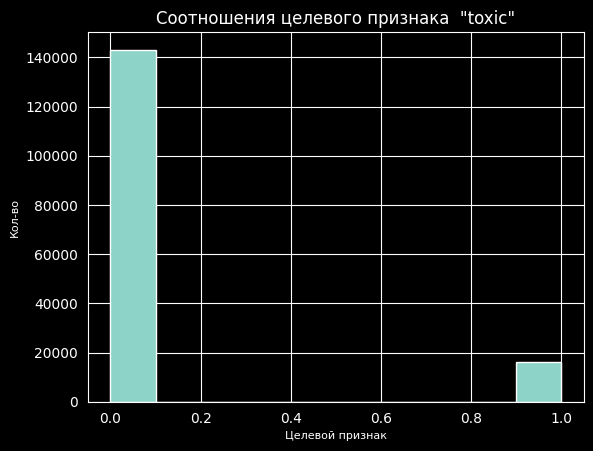

In [ ]:
df['toxic'].hist()
plt.xlabel('Целевой признак', fontsize= 8)
plt.ylabel('Кол-во', fontsize= 8)
plt.title('Соотношения целевого признака  "toxic"');

Присутствует дисбаланс в целевом признаке. Количество токсичных комментариев меньше. Учьтем это при обучении моделей.

Создадим функцию, которая очистит текст для будущей лемматизации при помощи регулярных выражений и функцию для упращения самого текста:

In [ ]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lemm_list])
    return lemm_text

In [ ]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = clear_text.lower().split()
    return ' '.join(clear_text)

In [ ]:
# загрузка необходимых компонентов
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

Проверим, что функции работают корректно на тексте первой строке :

In [ ]:
df.loc[0, 'text'] # было

In [ ]:
lemmatize(clear_text(df.loc[0, 'text'])) # стало

Применим эти функции к всему столбцу

In [ ]:
df['lemm_text'] = df['text'].apply(clear_text)
df['lemm_text'] = df['lemm_text'].apply(lemmatize)

df['lemm_text']

Для определения тематики и тональность текста, необходимо провести обучение на корпусе (это набор текстов, в котором эмоции и ключевые слова уже размечены).


In [ ]:
# Разделим датасет на тренировочную и тестовую выборки ( в пропорциях 4:1) соответственно от общих данных:
train_features, test_features, train_target, test_target = train_test_split(
    df['lemm_text'], df['toxic'], test_size=0.25, random_state=17)

In [ ]:
# Посмотрим на результат деления
train_features.shape, test_features.shape, train_target.shape, test_target.shape

Создададим корпуса слов для обучающей и тестовой выборок:

In [ ]:
train_corpus = train_features.values #.astype('U')
test_corpus = test_features.values #.astype('U')

In [ ]:
# загрузка необходимых файлов для английской библиотеки лемматизатора:
nltk.download('stopwords')

In [ ]:
# Создадим список, который содержит стоп-слова, и все они будут удалены из результирующих токенов
stop_words = stopwords.words('english')

Мешок слов учитывает частоту употребления слов. Оценка важности слова определяется величиной TF-IDF (от англ. term frequency, «частота терма, или слова»; inverse document frequency, «обратная частота документа, или текста»).

То есть TF отвечает за количество упоминаний слова в отдельном тексте, а IDF отражает частоту его употребления во всём корпусе.

Воспользуемся TfidfVectorizer и, чтобы почистить мешок слов, добавим в него стоп-слова:

In [ ]:
# Создадим счётчик, указав в нём стоп-слова, вызовем функцию .fit_transform() для обучающей выборки и .transform() для тестовой:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_tf_idf.fit_transform(train_corpus)
tf_idf_test = count_tf_idf.transform(test_corpus)

In [ ]:
# Посмотрим
print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

## Обучение

Обучим модели и оценим полученные результаты.



Создаём сводную таблицу для сбора и анализа  результатов

In [ ]:
analisys = pd.DataFrame({'model':[], 'F1_model':[], 'F1_on_train':[]})
all_models = []

Чтобы ускорить вычисления и подборать лучшие параметры, используем RandomizedSearchSV

In [ ]:
# создаём функцию для подбора параметров
def train_model(model, parameters):

    model_random = RandomizedSearchCV(
        estimator=model,
        param_distributions=parameters,
        scoring='f1',
        n_jobs=-1,
        cv=4,
        verbose=2
    )

    # подсчитаем скорость вычисления
    start = time()
    model_random.fit(tf_idf_train, train_target)
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %(time() - start))

    # высчитаем метрики
    f1 = model_random.best_score_
    f1_on_train = f1_score(train_target, model_random.predict(tf_idf_train))

    print('Лучшие параметры:', model_random.best_params_)
    print('F1 обученной модели:', f1)
    print('F1 на тренировочной выборке:', f1_on_train)

    # заполним все таблицы
    all_models.append(model_random)
    row = []
    row.extend([model, f1, f1_on_train])
    analisys.loc[len(analisys.index)] = row

    return model_random

Логистическая регрессия

In [ ]:
# Параметры рандомные
ran_lr = {
    "penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "class_weight": ['balanced', 'none'],
}

logr = LogisticRegression(max_iter=1000)

lr_random = train_model(logr, ran_lr) # обучим и сохраним значения

Дерево решений

In [ ]:
# Параметры рандомные
ran_grid_tree = {
    "max_depth": list(range(50, 56))
}

dtr = DecisionTreeClassifier()

dtr_random = train_model(dtr, ran_grid_tree)

Случайный лес

In [ ]:
# Параметры рандомные
ran_grid_forest = {
    'max_depth': [300, 310],
    'n_estimators': [12, 14],
}

rfc = RandomForestClassifier(n_jobs=-1)

rfc_random = train_model(rfc, ran_grid_forest)

LightGBM

In [ ]:
# Параметры рандомные
rand_lgbm_param = {
    'max_depth': [20, 25],
    'learning_rate': [0.1, 0.3]
}

gbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_jobs=-1
)

gbm_random= train_model(gbm, rand_lgbm_param)

XGBoost

In [ ]:
# Параметры рандомные
rand_xgb_param = {
    'max_depth': [6, 7, 8, 9],
    'learning_rate': [0.5, 1.0]
}

xb = xgb.XGBClassifier(booster='gbtree',
                      use_rmm=True,
                      n_jobs=-1)

xb_random = train_model(xb, rand_xgb_param)

Анализ полученных метрик и выбор модели:

## Выводы

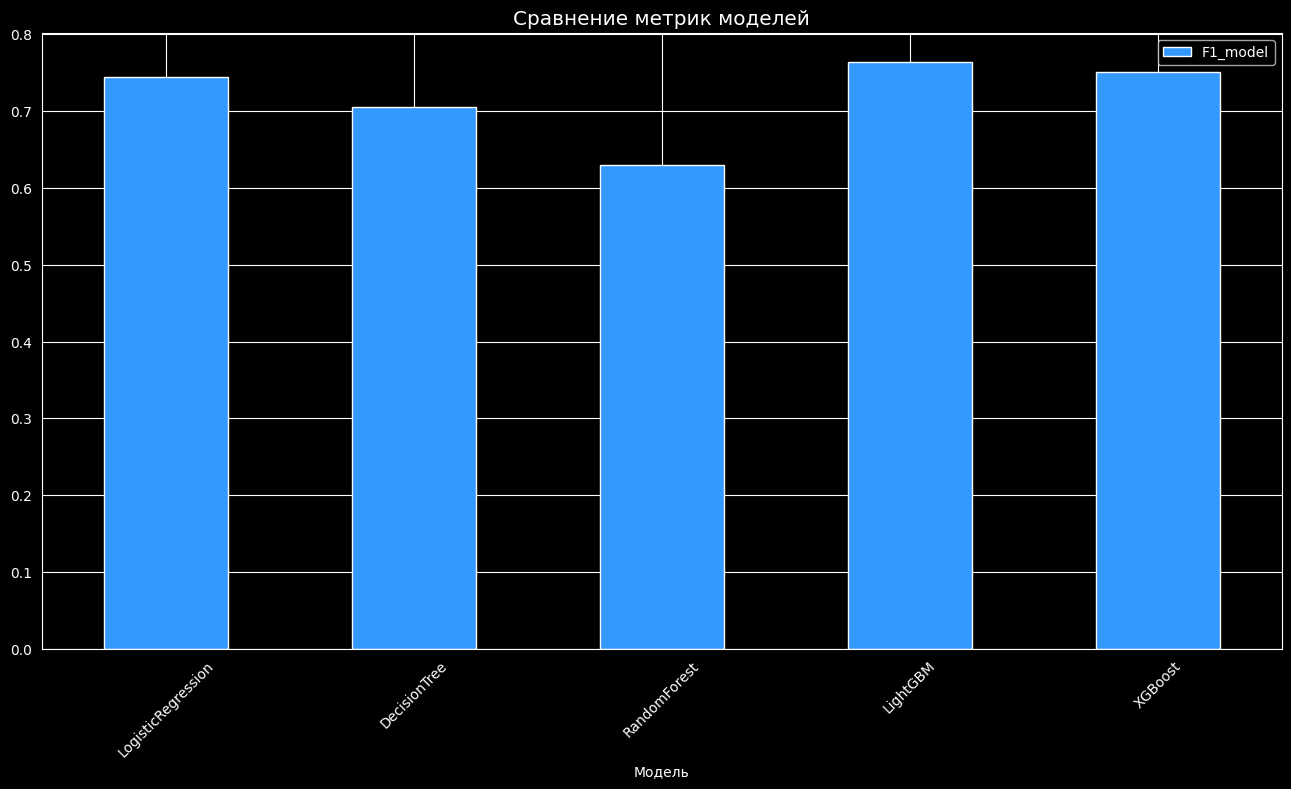

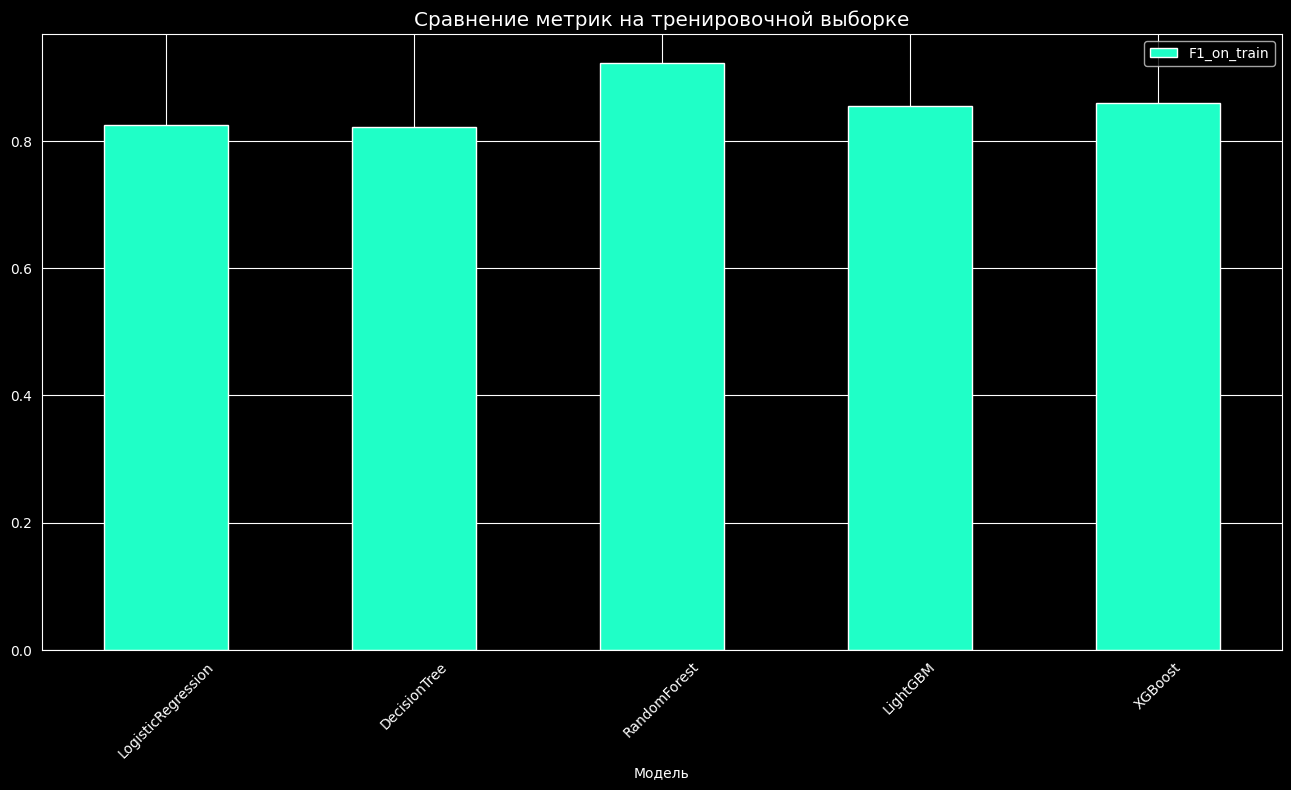

In [ ]:
all_names = pd.DataFrame({'names':[ 'LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM', 'XGBoost']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='F1_model', x='names', rot=45, figsize=(16, 8), color='#3399ff')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='F1_on_train', x='names', rot=45, figsize=(16, 8), color='#1fffc7')
plt.title('Сравнение метрик на тренировочной выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

### Общий вывод:

Исходя из полученных метрик качества моделей, лучшая модель на RandomizedSearchCV - LightGBM c параметрами max_depth: 25, learning_rate: 0.3. На тренировочной выборке, лучшую метрику показывает модель Случайного леса, но и худшую на подборе параметров, то есть модель переобучена и не показывает нужных метрик.

Для финальных результатов и проверки качества на тестовой выборке воспользуемся моделью LightGBM, которая уже обучена.

In [ ]:
# Подсчитаем метрики на тестовой выборке:
predicted = gbm_random.predict(tf_idf_test)
print('F1 лучшей модели на тестовой выборке:', f1_score(test_target, predicted))

Вывод:

Необходимые метрики достигнуты, модель LightGBM, обученная через RandomizedSearchCV, предсказывает с необходимой метрикой: F1 > 0.75.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
</b></u></font>
   
</div>